In [23]:
import optuna
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('/opt/ml/code/src/')

from utils import seed_everything, roc_auc_score
from model import lgbm
from features import feature_engineering

SEED = 42  # 랜덤 시드
seed_everything(SEED)  # 시드 고정

In [13]:
# 데이터 파일 읽기
data = pd.read_csv("/opt/ml/code/input/train.csv", parse_dates=["order_date"])

# 피처 엔지니어링 실행
train, test, y, features = feature_engineering(data, '2011-12')

categorical feature: []
train_set.shape (5722, 142) , test_set.shape (5914, 142)


In [16]:
def objective(trial):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',

        # num_leaves 값을 2-256까지 정수값 중에 사용
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        # max_bin 값을 128-256까지 정수값 중에 사용 
        'max_bin': trial.suggest_int('max_bin', 128, 256), 

        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),

        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),

        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),

        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # 트리 개수
        'n_estimators': 10000, 
        'early_stopping_rounds': 100,

        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),

        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,    
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds = lgbm(train, y, test, features, lgb_params, WANDB_USE=False)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(y, y_oof)
    
    return val_auc

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 3)

[I 2021-04-21 12:38:59,683] A new study created in memory with name: no-name-8aecce0d-8c96-4daf-a06a-1191c373208a
fold: 1, x_tr.shape: (5149, 139), x_val.shape: (573, 139)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.218391	valid_1's binary_logloss: 0.40567
Fold 1 | AUC: 0.8020952874541886
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 139), x_val.shape: (573, 139)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.235757	valid_1's binary_logloss: 0.411114
Fold 2 | AUC: 0.786639766038574
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 139), x_val.shape: (572, 139)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.148548	va

In [2]:
study.best_params

NameError: name 'study' is not defined

In [19]:
study.best_value

0.8130979884122805

In [20]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin,params_min_data_in_leaf,params_num_leaves,state
0,0,0.807665,2021-04-21 12:38:59.685835,2021-04-21 12:39:12.982180,0 days 00:00:13.296345,0.781126,2,0.544696,1.821840e-03,0.004719,197,17,111,COMPLETE
1,1,0.810410,2021-04-21 12:39:12.983302,2021-04-21 12:39:25.788977,0 days 00:00:12.805675,0.792609,7,0.891590,5.898737e-07,0.007924,217,26,82,COMPLETE
2,2,0.813098,2021-04-21 12:39:25.790236,2021-04-21 12:39:32.371980,0 days 00:00:06.581744,0.503488,4,0.458617,5.773692e-05,0.021381,151,37,71,COMPLETE


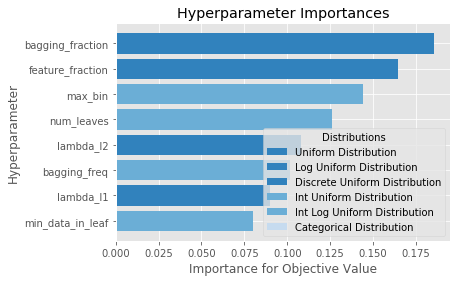

In [24]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

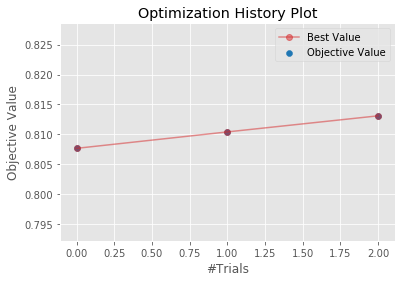

In [25]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

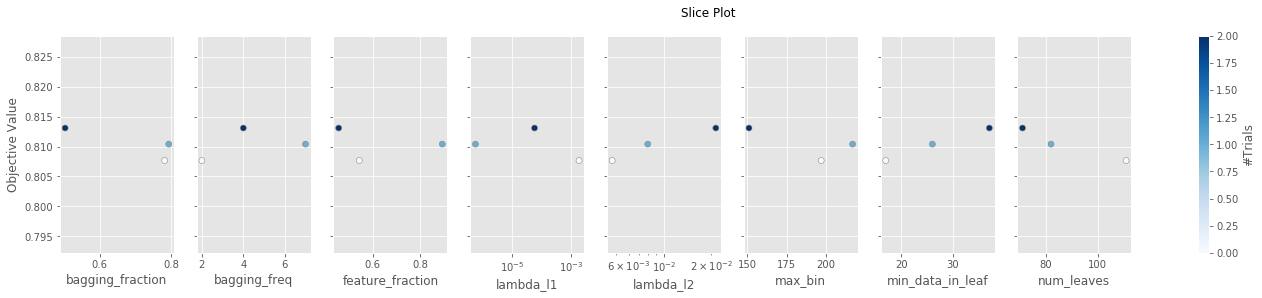

In [26]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

[W 2021-04-21 12:43:57,710] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


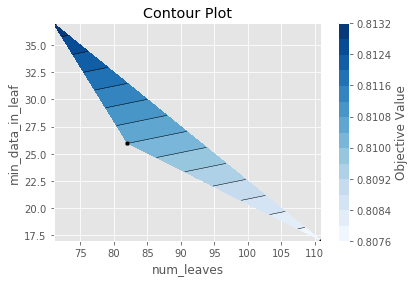

In [27]:
optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

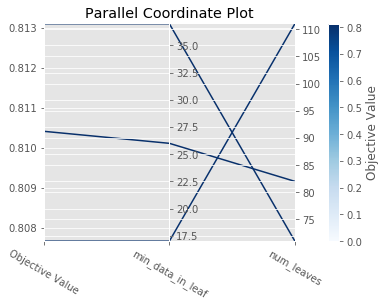

In [28]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['num_leaves','min_data_in_leaf'])
plt.show()